# Predicting the sale price of a house 

In November of 2020, information on 98 houses in the Duke Forest neighborhood of Durham, NC were scraped from the real estate marketplace [Zillow](https://zillow.com). The homes were all recently sold at the time of data collection.

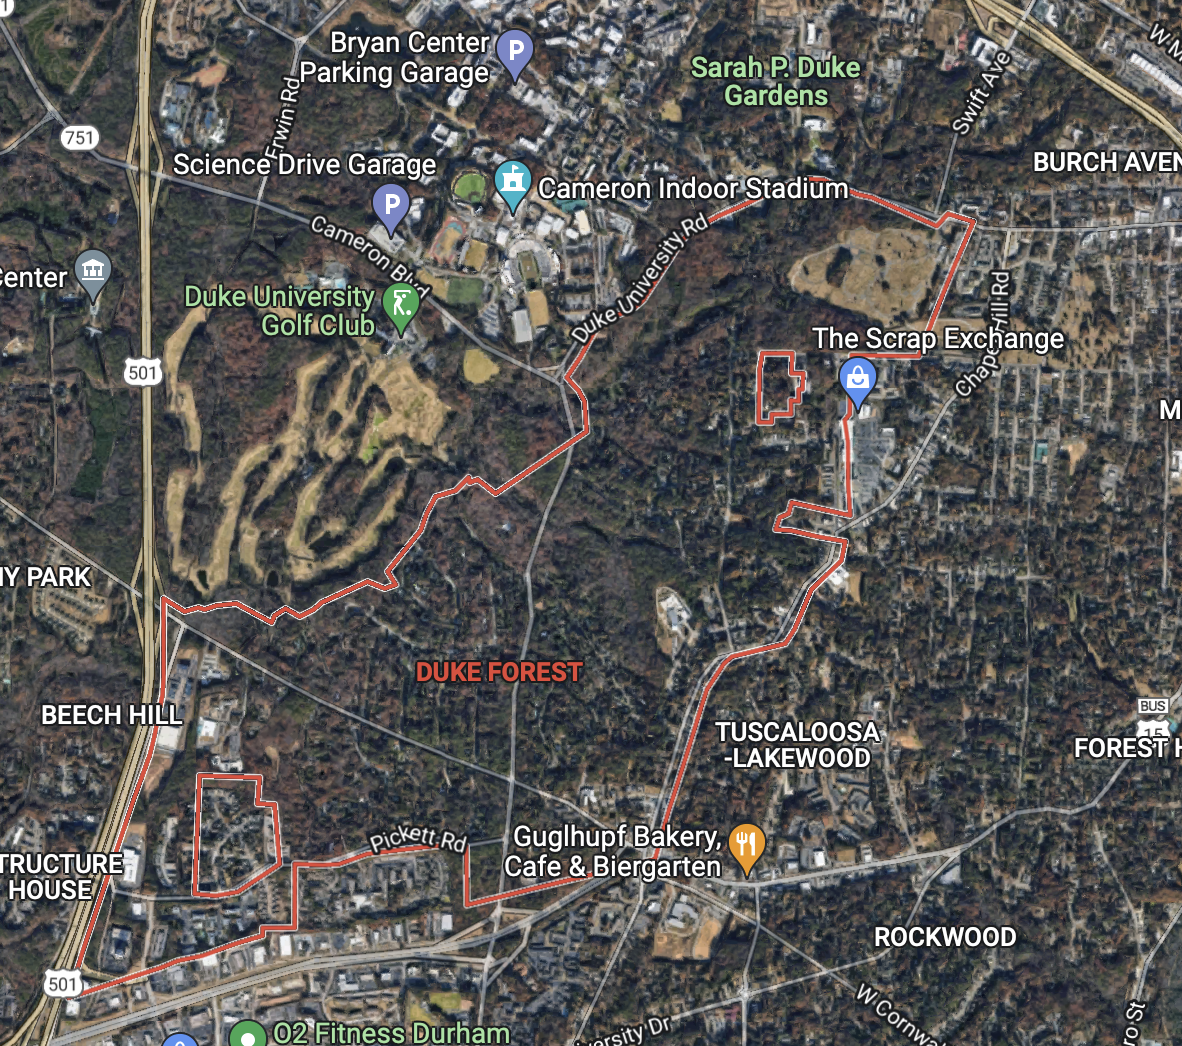


The goal of this case study is to build a model for predicting the sale price of a house based on a particular home’s characteristics.

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant  

sns.set_theme()

# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')


# machine learning
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Import data

In [2]:
df = pd.read_csv('duke-forest.csv')

## Data inspection

In [3]:
df

address    price  bed  bath  area  \
0          1 Learned Pl, Durham, NC 27705  1520000    3   4.0  6040   
1     1616 Pinecrest Rd, Durham, NC 27705  1030000    5   4.0  4475   
2   2418 Wrightwood Ave, Durham, NC 27705   420000    2   3.0  1745   
3        2527 Sevier St, Durham, NC 27705   680000    4   3.0  2091   
4         2218 Myers St, Durham, NC 27707   428500    4   3.0  1772   
..                                    ...      ...  ...   ...   ...   
93       2507 Sevier St, Durham, NC 27705   541000    4   4.0  2740   
94     1207 Woodburn Rd, Durham, NC 27705   473000    3   3.0  2171   
95   3008 Montgomery St, Durham, NC 27705   490000    4   4.0  2972   
96    1614 Pinecrest Rd, Durham, NC 27705   815000    4   4.0  3904   
97       2708 Circle Dr, Durham, NC 27705   674500    4   4.0  3766   

             type  year_built                          heating  cooling  \
0   Single Family        1972                       Other, Gas  central   
1   Single Family        1969                  Forced air, Gas  central   
2   Single Family        1959                  Forced air, Gas  central   
3   Single Family        1961  Heat pump, Other, Electric, Gas  central   
4   Single Family        2020                  Forced air, Gas  central   
..            ...         ...                              ...      ...   
93  Single Family        1960       Forced air, Heat pump, Gas  central   
94  Single Family        1955        Forced air, Electric, Gas    other   
95  Single Family        1984        Forced air, Electric, Gas  central   
96  Single Family        1970                  Forced air, Gas    other   
97  Single Family        1955        Forced air, Electric, Gas    other   

                                          parking   lot  hoa  \
0                                        0 spaces  0.97  NaN   
1                                Carport, Covered  1.38  NaN   
2                      Garage - Attached, Covered  0.51  NaN   
3                                Carport, Covered  0.84  NaN   
4                                        0 spaces  0.16  NaN   
..                                            ...   ...  ...   
93                               Carport, Covered  0.51  NaN   
94                                       0 spaces  0.61  NaN   
95         Garage - Attached, Off-street, Covered  0.65  NaN   
96  Garage - Attached, Garage - Detached, Covered  1.47  NaN   
97                                       0 spaces  0.73  NaN   

                                                  url  
0   https://www.zillow.com/homedetails/1-Learned-P...  
1   https://www.zillow.com/homedetails/1616-Pinecr...  
2   https://www.zillow.com/homedetails/2418-Wright...  
3   https://www.zillow.com/homedetails/2527-Sevier...  
4   https://www.zillow.com/homedetails/2218-Myers-...  
..                                                ...  
93  https://www.zillow.com/homedetails/2507-Sevier...  
94  https://www.zillow.com/homedetails/1207-Woodbu...  
95  https://www.zillow.com/homedetails/3008-Montgo...  
96  https://www.zillow.com/homedetails/1614-Pinecr...  
97  https://www.zillow.com/homedetails/2708-Circle...  

[98 rows x 13 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   address     98 non-null     object 
 1   price       98 non-null     int64  
 2   bed         98 non-null     int64  
 3   bath        98 non-null     float64
 4   area        98 non-null     int64  
 5   type        98 non-null     object 
 6   year_built  98 non-null     int64  
 7   heating     98 non-null     object 
 8   cooling     98 non-null     object 
 9   parking     98 non-null     object 
 10  lot         97 non-null     float64
 11  hoa         1 non-null      object 
 12  url         98 non-null     object 
dtypes: float64(2), int64(4), object(7)
memory usage: 10.1+ KB


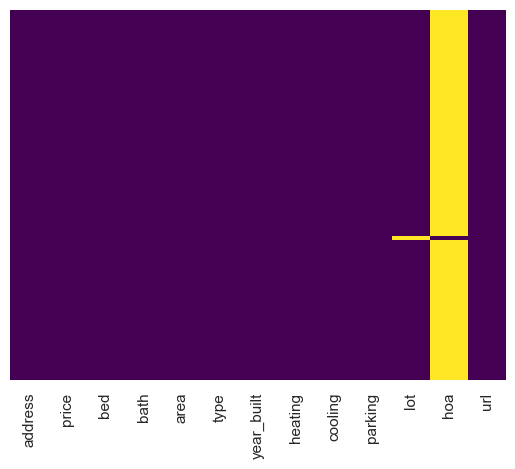

In [5]:
# show missing values (missing values - if present - will be displayed in yellow)
sns.heatmap(df.isnull(), 
            yticklabels=False,
            cbar=False, 
            cmap='viridis');

In [6]:
print(df.isnull().sum())

address        0
price          0
bed            0
bath           0
area           0
type           0
year_built     0
heating        0
cooling        0
parking        0
lot            1
hoa           97
url            0
dtype: int64


## Data transformation

In [7]:
# drop column with too many missing values
df = df.drop(['hoa'], axis=1)

# drop remaining row with one missing value
df = df.dropna()

In [8]:
# Drop irrelevant features
df = df.drop(['url', 'address'], axis=1)

In [9]:
print(df.isnull().sum())

price         0
bed           0
bath          0
area          0
type          0
year_built    0
heating       0
cooling       0
parking       0
lot           0
dtype: int64


In [10]:
# Convert data types
categorical_list = ['type', 'heating', 'cooling', 'parking']

for i in categorical_list:
    df[i] = df[i].astype("category")

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 97
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   price       97 non-null     int64   
 1   bed         97 non-null     int64   
 2   bath        97 non-null     float64 
 3   area        97 non-null     int64   
 4   type        97 non-null     category
 5   year_built  97 non-null     int64   
 6   heating     97 non-null     category
 7   cooling     97 non-null     category
 8   parking     97 non-null     category
 9   lot         97 non-null     float64 
dtypes: category(4), float64(2), int64(4)
memory usage: 7.3 KB


In [12]:
# summary statistics for all categorical columns
df.describe(include=['category']).transpose()

count unique              top freq
type       97      1    Single Family   97
heating    97     19  Forced air, Gas   34
cooling    97      2            other   52
parking    97     19         0 spaces   42

- Variable `type` has zero veriation (only single family) and therefore can be exluded from the analysis and the model. 

- We will also exclude `heating` and `parking` to keep this case as simple as possible.

In [13]:
df = df.drop(['type', 'heating', 'parking'], axis=1)
df

price  bed  bath  area  year_built  cooling   lot
0   1520000    3   4.0  6040        1972  central  0.97
1   1030000    5   4.0  4475        1969  central  1.38
2    420000    2   3.0  1745        1959  central  0.51
3    680000    4   3.0  2091        1961  central  0.84
4    428500    4   3.0  1772        2020  central  0.16
..      ...  ...   ...   ...         ...      ...   ...
93   541000    4   4.0  2740        1960  central  0.51
94   473000    3   3.0  2171        1955    other  0.61
95   490000    4   4.0  2972        1984  central  0.65
96   815000    4   4.0  3904        1970    other  1.47
97   674500    4   4.0  3766        1955    other  0.73

[97 rows x 7 columns]

## Data splitting

In [14]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_dataset

price  bed  bath  area  year_built  cooling   lot
26  385000    3   2.0  1831        1951  central  0.29
85  485000    4   3.0  2609        1962    other  0.52
2   420000    2   3.0  1745        1959  central  0.51
55  150000    3   1.0  1734        1945    other  0.16
69  105000    2   1.0  1094        1940    other  0.26
..     ...  ...   ...   ...         ...      ...   ...
96  815000    4   4.0  3904        1970    other  1.47
70  520000    4   3.0  2637        1968    other  0.65
20  270000    3   3.0  1416        1990    other  0.36
92  590000    5   3.0  3323        1980    other  0.43
73  592000    3   2.0  2378        1960    other  0.75

[78 rows x 7 columns]

## Exploratory data analysis

In [15]:
# summary statistics for all numerical columns
round(train_dataset.describe(),2).transpose()

count       mean        std       min        25%        50%  \
price        78.0  560762.18  243254.08  95000.00  421250.00  537500.00   
bed          78.0       3.81       0.74      2.00       3.00       4.00   
bath         78.0       3.10       0.92      1.00       2.50       3.00   
area         78.0    2831.40     986.38   1094.00    2095.25    2745.00   
year_built   78.0    1965.82      16.80   1923.00    1956.25    1961.50   
lot          78.0       0.59       0.23      0.15       0.45       0.56   

                  75%         max  
price       650000.00  1520000.00  
bed              4.00        6.00  
bath             4.00        5.00  
area          3261.75     6178.00  
year_built    1971.50     2020.00  
lot              0.69        1.47

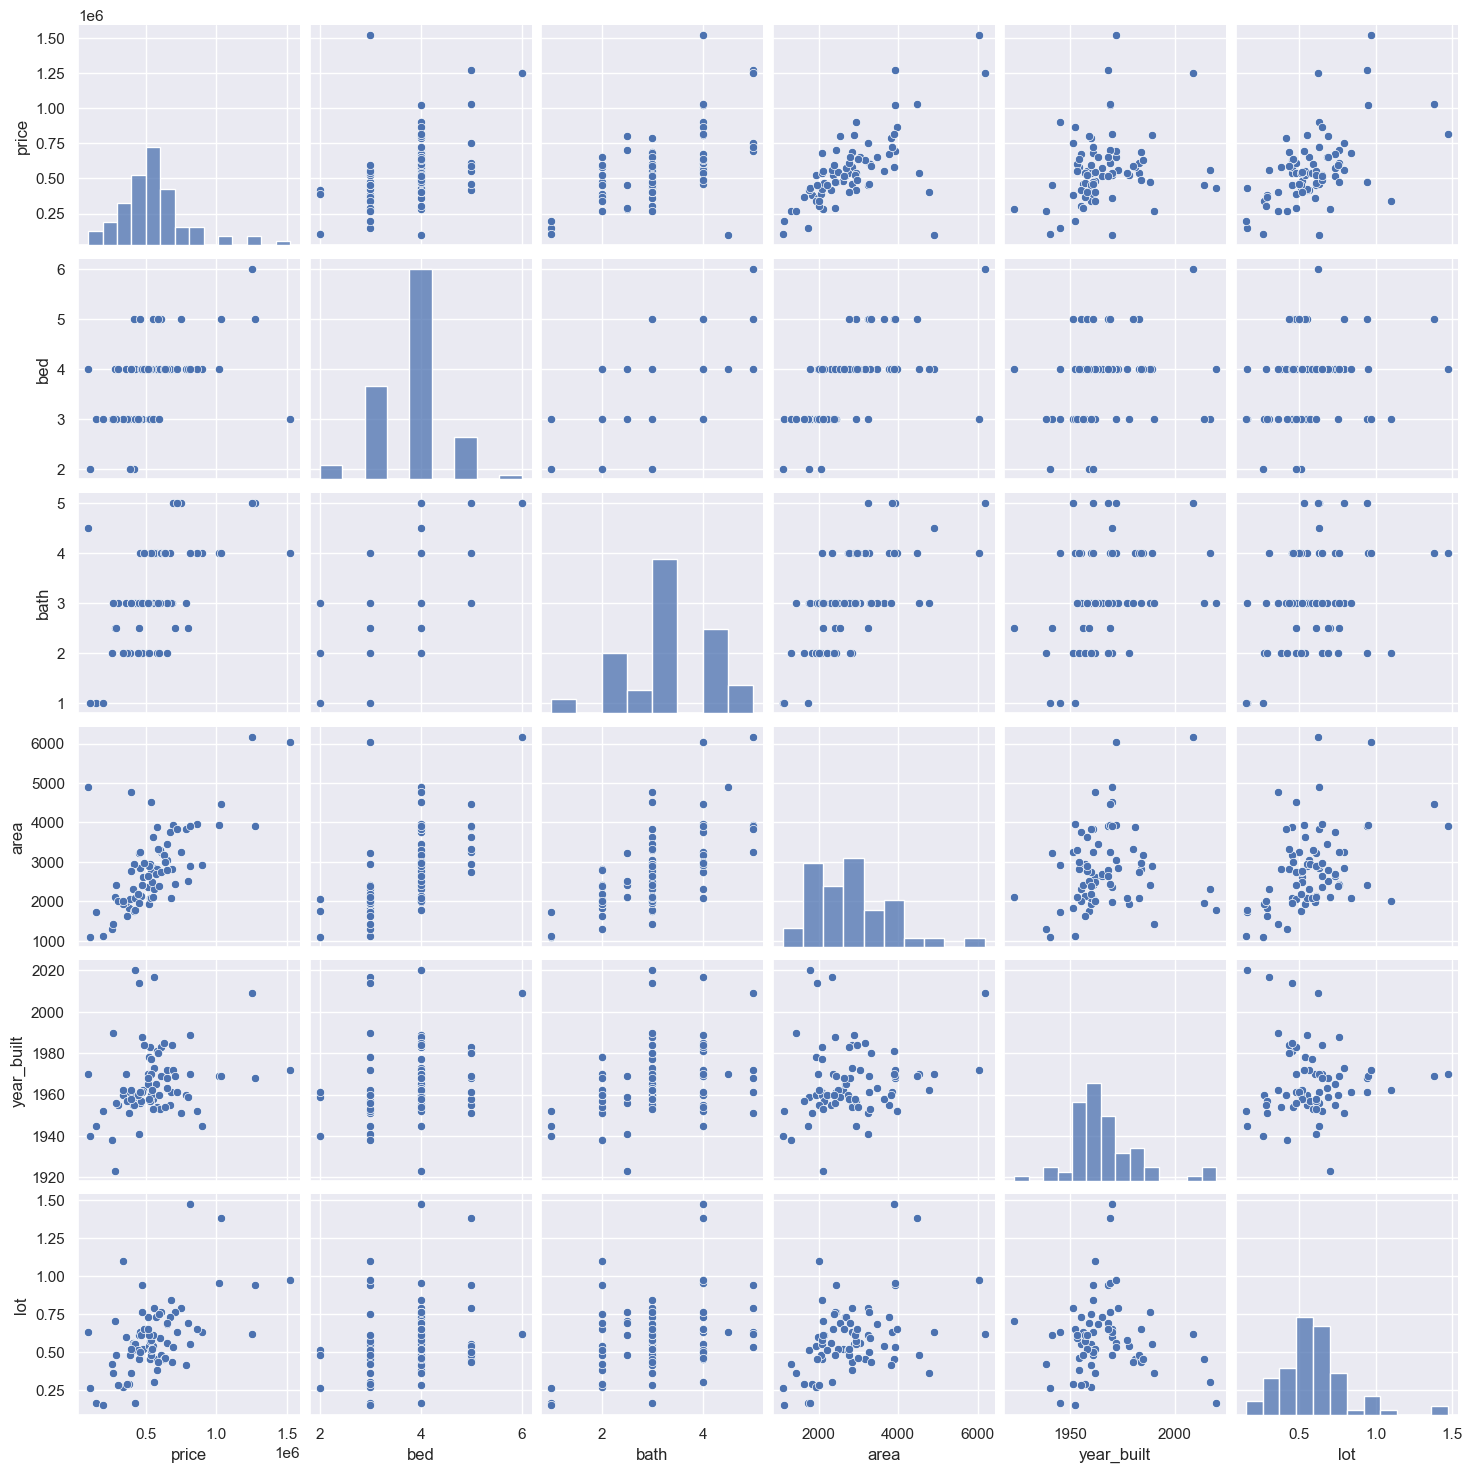

In [16]:
sns.pairplot(train_dataset);

## Correlation analysis

In [17]:
# Create correlation matrix for numerical variables
corr_matrix = train_dataset.drop(['cooling'], axis=1).corr()
corr_matrix

price       bed      bath      area  year_built       lot
price       1.000000  0.446668  0.593686  0.680012    0.248102  0.537264
bed         0.446668  1.000000  0.599660  0.560258    0.216696  0.248166
bath        0.593686  0.599660  1.000000  0.659879    0.351917  0.335490
area        0.680012  0.560258  0.659879  1.000000    0.165495  0.412836
year_built  0.248102  0.216696  0.351917  0.165495    1.000000 -0.047352
lot         0.537264  0.248166  0.335490  0.412836   -0.047352  1.000000

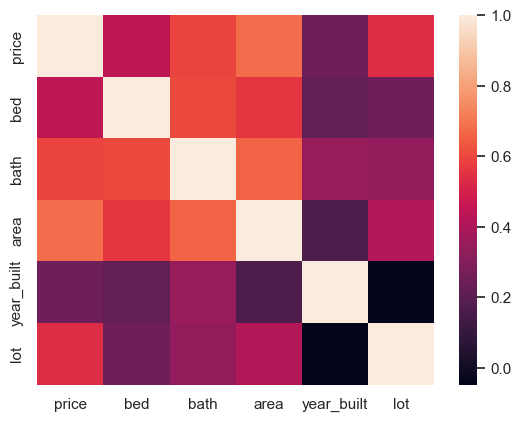

In [18]:
# Simple heatmap
heatmap = sns.heatmap(corr_matrix)

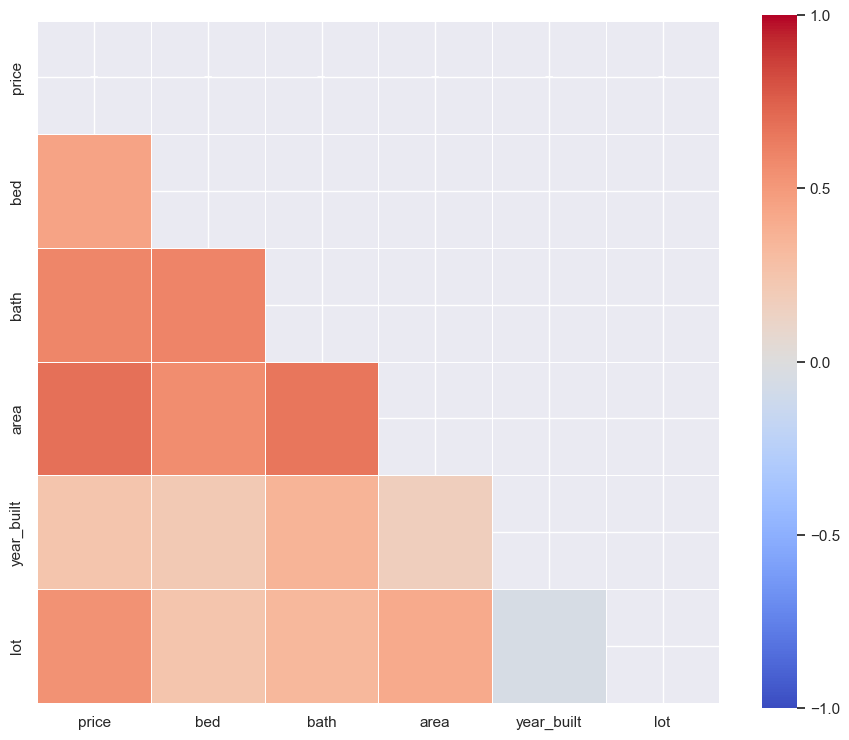

In [19]:
# Make a pretty heatmap

# Use a mask to plot only part of a matrix
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)]= True

# Change size
plt.subplots(figsize=(11, 15))

# Build heatmap with additional options
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask, 
                      square = True, 
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .6,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 10})

Instead of inspecting the correlation matrix, a better way to assess **multicollinearity** is to compute the variance inflation factor (VIF). Note that we ignore the intercept in this test.

- The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. 
- Typically in practice there is a small amount of collinearity among the predictors. 
- As a rule of thumb, a VIF value that exceeds 5 indicates a problematic amount of collinearity and the parameter estimates will have large standard errors because of this. 

Note that the function `variance_inflation_factor` expects the presence of a constant in the matrix of explanatory variables. Therefore, we use `add_constant` from statsmodels to add the required constant to the dataframe before passing its values to the function.

In [20]:
# choose features and add constant
features = add_constant(df[['bed', 'bath', 'area', 'lot']])
# create empty DataFrame
vif = pd.DataFrame()
# calculate vif
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
# add feature names
vif["Feature"] = features.columns

vif.round(2)

VIF Factor Feature
0       28.52   const
1        1.74     bed
2        2.17    bath
3        2.14    area
4        1.19     lot

We don't have a problematic amount of collinearity in our data.

## Modeling


In [21]:
# for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

In [22]:
# for categorical features  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [23]:
# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))
        ])

### Simple Regression

In [24]:
# Select features for simple regression
features = ['area']
X = df[features]

# Create response
y = df["price"]

In [25]:
# check feature
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 97
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   area    97 non-null     int64
dtypes: int64(1)
memory usage: 3.6 KB


In [26]:
# check label
y

0     1520000
1     1030000
2      420000
3      680000
4      428500
       ...   
93     541000
94     473000
95     490000
96     815000
97     674500
Name: price, Length: 97, dtype: int64

In [27]:
# check for missing values
print("Missing values X:",X.isnull().any(axis=1).sum())

print("Missing values Y:",y.isnull().sum())

Missing values X: 0
Missing values Y: 0


#### Data splitting

In [28]:
# Train Test Split
# Use random_state to make this notebook's output identical at every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model

In [29]:
# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [30]:
# show pipeline
set_config(display="diagram")
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10595ec50>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16819d150>)])),
                ('lm', LinearRegression())])

In [31]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([128046.72300033])

In [32]:
# Obtain model intercept
lm_pipe.named_steps['lm'].intercept_

565479.8701298701

#### Evaluation with training data

There are various options to evaluate a model in scikit-learn. Review this overview about [metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [33]:
X_train.head()

area
49  2902
71  2165
69  1094
15  2750
39  2334

In [34]:
y_pred = lm_pipe.predict(X_train)

In [35]:
r2_score(y_train, y_pred)  

0.35694914972541547

In [36]:
mean_squared_error(y_train, y_pred)

29537647395.092506

In [37]:
# RMSE
mean_squared_error(y_train, y_pred, squared=False)

171865.20123367762

In [38]:
mean_absolute_error(y_train, y_pred)

115668.27028304595

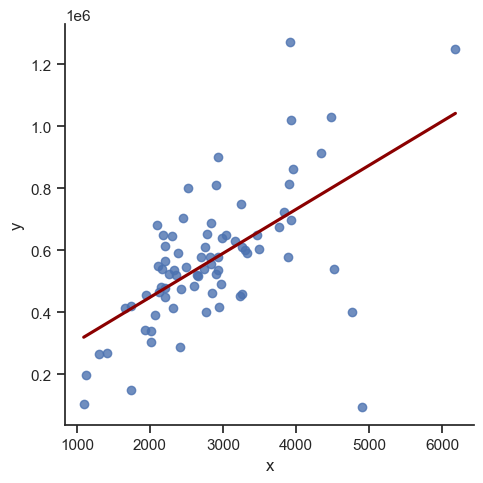

In [39]:
sns.set_theme(style="ticks")

# Plot with Seaborn

# We first need to create a DataFrame
df_train = pd.DataFrame({'x': X_train['area'], 'y':y_train})

sns.lmplot(x='x', y='y', data=df_train, line_kws={'color': 'darkred'}, ci=False);

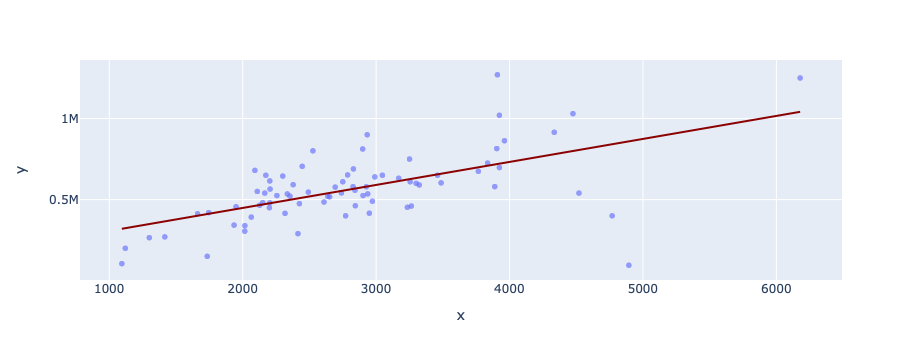

In [40]:
import plotly.io as pio
import plotly.offline as py
import plotly.express as px

# Plot with Plotly Express
fig = px.scatter(x=X_train['area'], y=y_train, opacity=0.65, 
                trendline='ols', trendline_color_override='darkred');
fig.show()

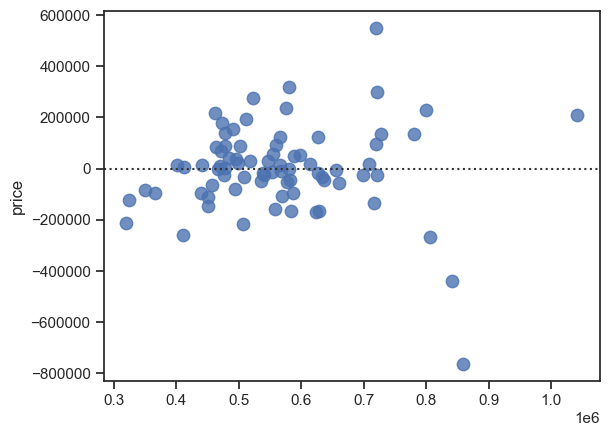

In [41]:
sns.residplot(x=y_pred, y=y_train, scatter_kws={"s": 80});

Let's take a look at the wrongest predictions:

In [42]:
# create dataframe
df_error = pd.DataFrame(
    { "y": y_train,
      "y_pred": y_pred,
      "error": y_pred - y_train
    })

# sort by error, select top 10 and get index
error_index = df_error.sort_values(by=['error']).nlargest(10, 'error').index

# show corresponding data observations
df.iloc[error_index]

price  bed  bath  area  year_built  cooling   lot
65  609000    5   4.0  3175        2016    other  0.47
84  567000    4   4.0  3931        1982    other  0.39
88  480000    2   2.0  2203        1984    other  0.42
55  150000    3   1.0  1734        1945    other  0.16
19  290000    3   2.5  2414        1956    other  0.48
70  520000    4   3.0  2637        1968    other  0.65
16  452500    3   2.5  3234        1941    other  0.61
92  590000    5   3.0  3323        1980    other  0.43
48  416000    5   3.0  2949        1955    other  0.55
57  400000    4   3.0  2771        1958  central  0.52

#### Evaluation with test data

In [43]:
y_pred = lm_pipe.predict(X_test)

In [44]:
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('RSQUARE:', r2_score(y_test, y_pred))

MSE: 23209825917.075756
RMSE: 152347.71385575747
RSQUARE: 0.6639149484557161


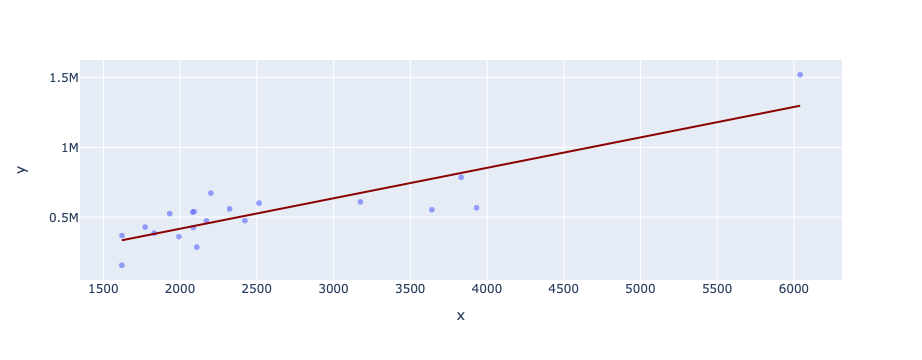

In [45]:
# Plot with Plotly Express
fig = px.scatter(x=X_test['area'], y=y_test, opacity=0.65, 
                trendline='ols', trendline_color_override='darkred')

fig.show()

Model generalization on unseen data (see [plotly documentation](https://plotly.com/python/ml-regression/))


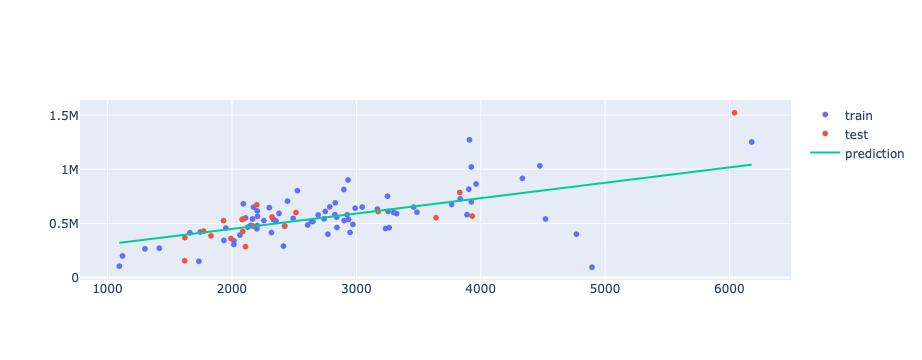

In [46]:
import numpy as np
import plotly.graph_objects as go

x_range = pd.DataFrame({ 'area': np.linspace(X_train['area'].min(), X_train['area'].max(), 100)})
y_range =  lm_pipe.predict(x_range)

go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range.area, y=y_range, name='prediction')
])


### Multiple regression

In [47]:
# Select features for multiple regression
features= [
 'bed',
 'bath',
 'area',
 'year_built',
 'cooling',
 'lot'
  ]
X = df[features]

X.info()
print("Missing values:",X.isnull().any(axis = 1).sum())

# Create response
y = df["price"]

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 97
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   bed         97 non-null     int64   
 1   bath        97 non-null     float64 
 2   area        97 non-null     int64   
 3   year_built  97 non-null     int64   
 4   cooling     97 non-null     category
 5   lot         97 non-null     float64 
dtypes: category(1), float64(2), int64(3)
memory usage: 6.8 KB
Missing values: 0


#### Data splitting

In [48]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model

In [49]:
# Create pipeline with model
lm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lm', LinearRegression())
                        ])

In [50]:
# show pipeline
set_config(display="diagram")
# Fit model
lm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x10595ec50>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16819d150>)])),
                ('lm', LinearRegression())])

In [51]:
# Obtain model coefficients
lm_pipe.named_steps['lm'].coef_

array([ 37501.22436002,  50280.7007969 ,  30312.97805437,  27994.3520344 ,
        79024.39994917,  23467.73502737, -23467.73502737])

#### Evaluation with test data

In [52]:
y_pred = lm_pipe.predict(X_test)

In [53]:
r2_score(y_test, y_pred)

0.48258367314488027